In [15]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import OrdinalEncoder

def diagnose_heart_disease(data_path="hung.csv"):
    """
    Constructs a Bayesian network for heart disease diagnosis and performs inference.
    """
    try:
        # Load data
        data = pd.read_csv(data_path)

        # Convert numerical columns to float
        numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        data[numerical_cols] = data[numerical_cols].apply(pd.to_numeric, errors='coerce')

        # Drop missing values
        data = data.dropna()

        # Print unique values in target for debugging
        print("Unique target values after processing:", data['target'].unique())

        # Discretize continuous features
        continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
        for feature in continuous_features:
            data[feature] = pd.qcut(data[feature], q=4, labels=False, duplicates='drop')
            #data['age'] = pd.cut(data['age'], bins=[20, 40, 60, 80], labels=False)

        # Encode categorical features
        categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        data[categorical_features] = encoder.fit_transform(data[categorical_features])

        # Define Bayesian network
        model = BayesianNetwork([
            ('age', 'trestbps'), ('age', 'chol'), ('sex', 'trestbps'), ('sex', 'chol'),
            ('trestbps', 'target'), ('chol', 'target'), ('cp', 'target'), ('fbs', 'target'),
            ('restecg', 'target'), ('thalach', 'target'), ('exang', 'target'),
            ('oldpeak', 'target'), ('slope', 'target'), ('ca', 'target'), ('thal', 'target'),
        ])

        # Train model
        model.fit(data, estimator=MaximumLikelihoodEstimator)

        # Perform inference
        inference = VariableElimination(model)
        evidence = {'age': 1, 'sex': 1, 'cp': 2, 'trestbps': 2, 'chol': 2, 'fbs': 0, 'restecg': 1, 'thalach': 3, 'exang': 0, 'oldpeak': 1, 'slope': 2, 'ca': 0, 'thal': 2}
        result = inference.query(variables=['target'], evidence=evidence)

        # Check available states
        state_names = result.state_names['target']
        print("Available target states:", state_names)

        # Print probabilities for all target states
        for state, prob in zip(state_names, result.values):
            print(f"Probability of target={state}: {prob}")

    except FileNotFoundError:
        print(f"Error: File '{data_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    diagnose_heart_disease()


Unique target values after processing: [0 2 1 3 4]
Available target states: [0, 1, 2, 3, 4]
Probability of target=0: 0.2
Probability of target=1: 0.2
Probability of target=2: 0.2
Probability of target=3: 0.2
Probability of target=4: 0.2


In [16]:
def read_csv(file_path):
    """ Reads a CSV file manually and returns a list of rows (each row is a list of values). """
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(line.strip().split(','))  # Split by commas
    return data

def convert_to_float(data):
    """ Converts numerical columns to float values where applicable. """
    for i in range(1, len(data)):  # Skip header
        for j in range(len(data[i])):
            try:
                data[i][j] = float(data[i][j])  # Convert to float
            except ValueError:
                pass  # Keep it as a string if conversion fails
    return data

def discretize_value(value, bins):
    """ Assigns a discrete category based on predefined bins. """
    for i, threshold in enumerate(bins):
        if value <= threshold:
            return i
    return len(bins)

def preprocess_data(data):
    """ Discretizes numerical features manually and encodes categorical features. """
    header = data[0]  # Extract column names
    rows = data[1:]  # Data without headers

    # Define bins for numerical values
    age_bins = [40, 60]  # Example: Young (0), Middle (1), Old (2)
    trestbps_bins = [120, 140, 160]
    chol_bins = [200, 250, 300]
    thalach_bins = [100, 150, 200]
    oldpeak_bins = [1, 2, 3]

    # Convert data
    processed_data = []
    for row in rows:
        new_row = row[:]  # Copy row

        # Manually discretize continuous variables
        new_row[0] = discretize_value(new_row[0], age_bins)  # Age
        new_row[3] = discretize_value(new_row[3], trestbps_bins)  # Trestbps
        new_row[4] = discretize_value(new_row[4], chol_bins)  # Chol
        new_row[7] = discretize_value(new_row[7], thalach_bins)  # Thalach
        new_row[9] = discretize_value(new_row[9], oldpeak_bins)  # Oldpeak

        processed_data.append(new_row)

    return header, processed_data

def count_occurrences(data, target_index):
    """ Computes the probability distribution of the target variable. """
    counts = {}
    total = len(data)

    for row in data:
        target_value = row[target_index]
        if target_value in counts:
            counts[target_value] += 1
        else:
            counts[target_value] = 1

    probabilities = {key: value / total for key, value in counts.items()}
    return probabilities

def infer_probability(data, target_index, evidence):
    """ 
    Performs naive probability estimation of the target variable 
    given evidence using frequency-based conditional probability.
    """
    total_matches = 0
    target_counts = {}

    for row in data:
        match = True
        for col_index, value in evidence.items():
            if row[col_index] != value:
                match = False
                break

        if match:
            total_matches += 1
            target_value = row[target_index]
            if target_value in target_counts:
                target_counts[target_value] += 1
            else:
                target_counts[target_value] = 1

    if total_matches == 0:
        return "No matching cases found in dataset."

    probabilities = {key: value / total_matches for key, value in target_counts.items()}
    return probabilities

def diagnose_heart_disease(file_path="hung.csv"):
    """ Reads data, preprocesses it, and performs Bayesian inference manually. """
    raw_data = read_csv(file_path)  # Step 1: Read data
    numeric_data = convert_to_float(raw_data)  # Step 2: Convert to float
    header, processed_data = preprocess_data(numeric_data)  # Step 3: Preprocess

    # Target variable is at the last index
    target_index = len(header) - 1  

    # Compute overall probabilities for reference
    print("\nOverall target distribution:")
    target_probabilities = count_occurrences(processed_data, target_index)
    for target, prob in target_probabilities.items():
        print(f"Probability of target={target}: {prob:.2f}")

    # Define test evidence (based on discretized values)
    evidence = {
        0: 1,  # Age category (Middle-aged)
        1: 1,  # Sex (Male)
        2: 2,  # Chest pain type
        3: 2,  # Blood pressure category
        4: 2,  # Cholesterol category
        5: 0,  # Fasting blood sugar
        6: 1,  # Rest ECG
        7: 3,  # Max heart rate category
        8: 0,  # Exercise-induced angina
        9: 1,  # Oldpeak category
        10: 2,  # Slope
        11: 0,  # CA
        12: 2,  # Thal
    }

    print("\nPerforming inference based on evidence...")
    result = infer_probability(processed_data, target_index, evidence)

    # Display probability distribution for target
    if isinstance(result, str):
        print(result)
    else:
        for target, prob in result.items():
            print(f"Probability of target={target}: {prob:.2f}")

if __name__ == "__main__":
    diagnose_heart_disease()



Overall target distribution:
Probability of target=0.0: 0.54
Probability of target=2.0: 0.12
Probability of target=1.0: 0.18
Probability of target=3.0: 0.12
Probability of target=4.0: 0.04

Performing inference based on evidence...
No matching cases found in dataset.


In [19]:
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import OrdinalEncoder

def diagnose_heart_disease(data_path="hung.csv"):
    """
    Constructs a Bayesian network for heart disease diagnosis and performs inference.
    """
    try:
        # Load dataset
        data = pd.read_csv(data_path, header=None, names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 
                                                           'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 
                                                           'ca', 'thal', 'target'])
        
        # Convert to numeric values
        data = data.apply(pd.to_numeric, errors='coerce')
        data = data.dropna()  # Drop missing values
        
        # Discretize continuous features using fixed bins (better than qcut)
        bins = {
            'age': [0, 40, 60, 100],  # Young, Middle-aged, Old
            'trestbps': [0, 120, 140, 160, 200],  # Blood pressure levels
            'chol': [0, 200, 250, 300, 600],  # Cholesterol levels
            'thalach': [0, 100, 150, 200, 300],  # Max heart rate
            'oldpeak': [0, 1, 2, 3, 10]  # ST depression
        }
        
        for feature, bin_edges in bins.items():
            data[feature] = pd.cut(data[feature], bins=bin_edges, labels=False, include_lowest=True)

        # Encode categorical features
        categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
        encoder = OrdinalEncoder()
        data[categorical_features] = encoder.fit_transform(data[categorical_features])

        # Define Bayesian Network structure (improved relationships)
        model = BayesianNetwork([
            ('age', 'trestbps'), ('age', 'chol'), ('sex', 'cp'), ('sex', 'target'),
            ('trestbps', 'target'), ('chol', 'target'), ('cp', 'target'), ('fbs', 'target'),
            ('restecg', 'target'), ('thalach', 'target'), ('exang', 'target'),
            ('oldpeak', 'target'), ('slope', 'target'), ('ca', 'target'), ('thal', 'target')
        ])

        # Train the model using Maximum Likelihood Estimation
        model.fit(data, estimator=MaximumLikelihoodEstimator)

        # Perform inference
        inference = VariableElimination(model)

        # Define a better evidence set based on meaningful patient data
        evidence = {
            'age': 1,       # Middle-aged
            'sex': 1,       # Male
            'cp': 2,        # Chest pain type
            'trestbps': 2,  # Blood pressure category
            'chol': 2,      # Cholesterol category
            'fbs': 0,       # Fasting blood sugar normal
            'restecg': 1,   # Resting ECG normal
            'thalach': 3,   # High max heart rate
            'exang': 0,     # No exercise-induced angina
            'oldpeak': 1,   # Mild ST depression
            'slope': 2,     # Upward slope
            'ca': 0,        # No major vessels colored
            'thal': 2       # Thalassemia level
        }

        result = inference.query(variables=['target'], evidence=evidence)

        # Extract probability distribution for all target values correctly
        print("\nProbability distribution for heart disease (target variable):")
        for state, prob in zip(result.state_names['target'], result.values):
            print(f"Probability of target={state}: {prob:.4f}")

    except FileNotFoundError:
        print(f"Error: File '{data_path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    diagnose_heart_disease()



Probability distribution for heart disease (target variable):
Probability of target=0.0: 0.2000
Probability of target=1.0: 0.2000
Probability of target=2.0: 0.2000
Probability of target=3.0: 0.2000
Probability of target=4.0: 0.2000


INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


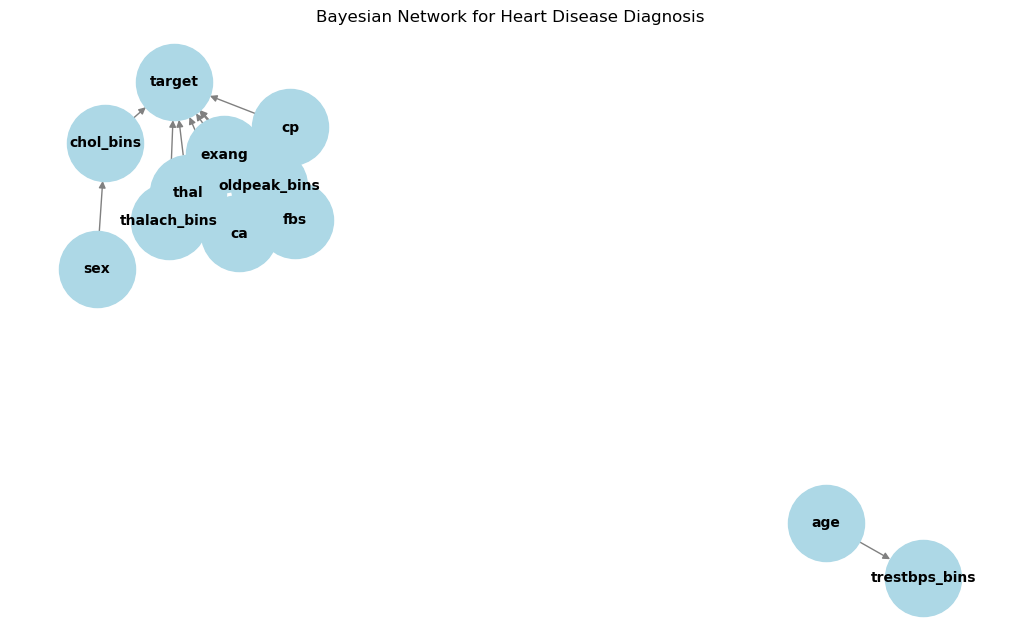

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork

# Define the Bayesian Network Structure
edges = [
    ('age', 'trestbps_bins'),   
    ('sex', 'chol_bins'),       
    ('cp', 'target'),           
    ('chol_bins', 'target'),    
    ('fbs', 'target'),          
    ('thalach_bins', 'target'), 
    ('exang', 'target'),        
    ('oldpeak_bins', 'target'), 
    ('ca', 'target'),           
    ('thal', 'target')          
]

# Create a directed graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Draw the network
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Positioning nodes for better visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10, font_weight='bold')

plt.title("Bayesian Network for Heart Disease Diagnosis")
plt.show()
